Jack Rogers

903848157

In [26]:
## Data: Dataset on breast cancer in Wisconsin
# Problem: Classify as either malignant or benign

# Dataset Location: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

# From Kaggle: Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.
#              They describe characteristics of the cell nuclei present in the image.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pdpbox.pdp import pdp_isolate, pdp_plot

In [2]:
cancer = pd.read_csv('data.csv')
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

PROCESSING OF DEPENDENT VARIABLE

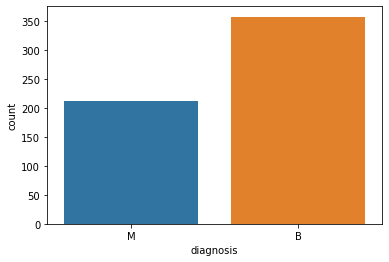

In [3]:
sns.countplot(cancer['diagnosis'],label='Count')

The dependent variable classes are somewhat imbalanced, but they are split approximately 60/40 for benign and malignant, respectively.

Since this is not a very extreme imbalance (the less frequent class makes up well over a third of the diagnoses), I am not going to use bootstrapping or sampling to balance the classes.

In [4]:
# Coding the dependent variable to numerical
cancer.loc[cancer['diagnosis'] == 'B', 'diagnosis'] = 0
cancer.loc[cancer['diagnosis'] == 'M', 'diagnosis'] = 1

cancer['diagnosis'] = cancer['diagnosis'].astype(int)

FEATURE SELECTION

Since there are 30 predictors in the raw dataset, I want to cut down on the number of variables to reduce the risk of error/overfitting.

There are only 10 characteristics, but each characteristic has 3 attributes (mean, worst, se). To simplify the model while still retaining maximum predictive power, I am only going to use the "worst" attributes, leaving the dataset with 10 predictors.

The mean attribute is a little too high-level and the se (standard error) attribute is a little too in-detail. The "worst" attribute, however, still gives us enough detail to make predictions on the diagnosis while also reducing the complexity of the model.

In [5]:
# Dropping standard-error and mean attributes to reduced model complexity
cols_todrop = []

for col in cancer.columns :
    if col.endswith('se') or col.endswith('mean') :
        cols_todrop.append(col)

cancer_reduced = cancer.drop(cols_todrop,axis=1)

The two predominant measurements of the breast masses are 1.) Size and 2.) Shape. Each feature measures one of these categories to an extent. For example: area measures size, and concavity measures shape.

Since there are multiple predictors measuring each category, there is a good chance of correlation <i>between</i> predictor variables. 

Using a correlation plot gives insight into correlations between each feature.

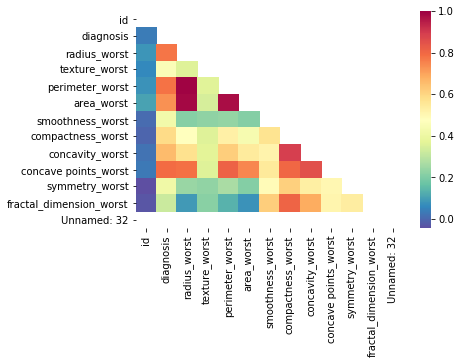

In [6]:
# Heatmap of correlations
corrs = cancer_reduced.corr()
mask = np.triu(np.ones_like(corrs))
sns.heatmap(corrs, mask=mask,cmap='Spectral_r')

As shown in the heatmap, there are a few size-measuring variables that are highly correlated. This multicollinearity can be a problem, because it might cloud our understanding of feature importances and call into question the independence of the correlated predictors.

Eliminating all but one of highly-correlated predictors can improve model interpretability while reducing model complexity.

"Size" Highly-Correlated Predictors: perimeter, area, radius

"Shape" Highly-Correlated Predictors: compactness, concavity

Perimeter and radius can be dropped, while keeping the area variable.
Additionally, dropping concavity would likely be best because there is already another related variable ("concave points")

In [7]:
# Dropping correlated predictors to further reduce complexity
corr_vars = ['perimeter_worst','radius_worst','concavity_worst']
cancer_reduced.drop(corr_vars,axis=1,inplace=True)

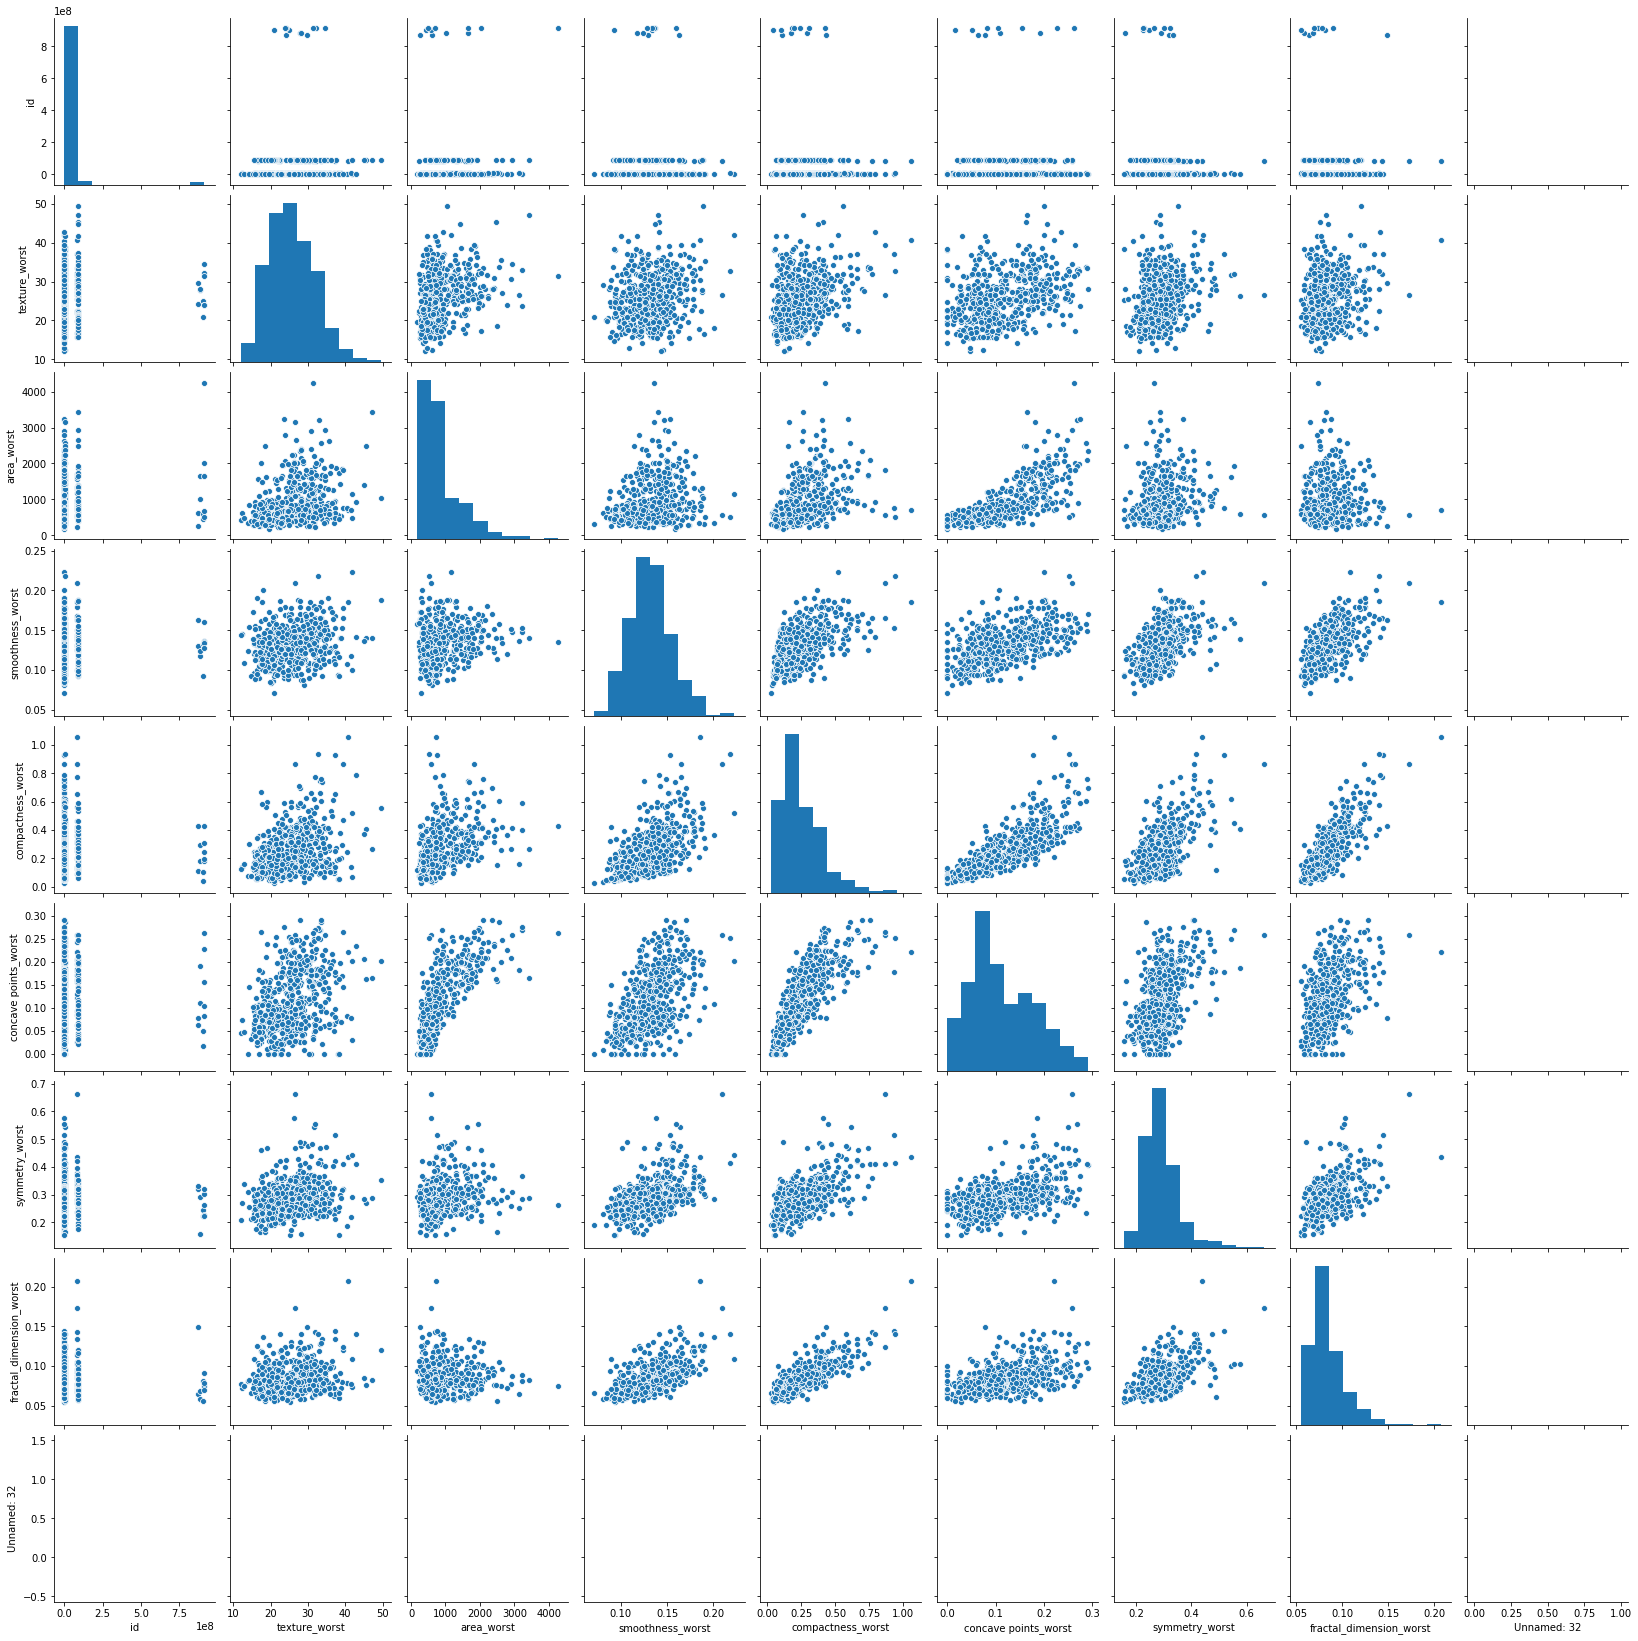

In [8]:
sns.pairplot(cancer_reduced.drop('diagnosis',axis=1))
plt.show()

From the distributions above, it is clear that a couple of the predictors are skewed right.

A log transformation could help even the distributions, and the variables that could benefit most from being log-transformed are :

1.) area_worst  2.) compactness_worst
    

In [9]:
# Log-transform and rename columns that are heavily skewed

cols_tolog = ['area_worst','compactness_worst']

for col in cols_tolog :
    cancer_reduced[col].apply(np.log)
    cancer_reduced.rename(columns = {col:'log_{}'.format(col)}, inplace=True)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split

In [11]:
X = cancer_reduced.drop(['diagnosis','Unnamed: 32'],axis=1)
y = cancer_reduced['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=10)

In [12]:
evaluation = dict()

<b> RANDOM FOREST CLASSIFIER</b>

In [13]:
for i in [1,2,3,4,5] :
    rfc = RandomForestClassifier(max_features = 'sqrt', max_depth = i)
    rfc.fit(X_train, y_train)
    preds = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    print('{} : {}'.format(i, accuracy))

1 : 0.9300699300699301
2 : 0.951048951048951
3 : 0.9790209790209791
4 : 0.958041958041958
5 : 0.972027972027972


A max depth of 3 seems to be the most accurate, so we will fit our model with that hyperparameter.

In [14]:
rfc = RandomForestClassifier(max_depth = 3, max_features = 'sqrt', random_state=10)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
accuracy = accuracy_score(y_test, preds)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

evaluation['RandForest'] = [accuracy, sensitivity, specificity]

[[90  1]
 [ 3 49]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        91
           1       0.98      0.94      0.96        52

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



<b> K-NEAREST NEIGHBORS CLASSIFIER </b>

In [15]:
for n in range(1,7) :
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    print('{} neighbors: {}'.format(n, accuracy))

1 neighbors: 0.8181818181818182
2 neighbors: 0.7622377622377622
3 neighbors: 0.7762237762237763
4 neighbors: 0.7132867132867133
5 neighbors: 0.7272727272727273
6 neighbors: 0.7272727272727273


In [16]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
accuracy = accuracy_score(y_test, preds)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

evaluation['KNN'] = [accuracy, sensitivity, specificity]

[[81 10]
 [16 36]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        91
           1       0.78      0.69      0.73        52

    accuracy                           0.82       143
   macro avg       0.81      0.79      0.80       143
weighted avg       0.82      0.82      0.82       143



<b> DECISION TREE CLASSIFIER </b>

In [17]:
for depth in range(1,8) :
    dtc = DecisionTreeClassifier(max_depth=depth)
    dtc.fit(X_train, y_train)
    preds = dtc.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    print('{} depth: {}'.format(depth, accuracy))

1 depth: 0.9230769230769231
2 depth: 0.951048951048951
3 depth: 0.9790209790209791
4 depth: 0.958041958041958
5 depth: 0.965034965034965
6 depth: 0.9440559440559441
7 depth: 0.9230769230769231


In [18]:
dtc = DecisionTreeClassifier(max_depth = 3, random_state=10)
dtc.fit(X_train, y_train)
preds = dtc.predict(X_test)
accuracy = accuracy_score(y_test, preds)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

evaluation['DecisionTree'] = [accuracy, sensitivity, specificity]

[[90  1]
 [ 2 50]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        91
           1       0.98      0.96      0.97        52

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



<b> EVALUATION </b>

Because we are predicting whether someone has a malignant, or dangerous, form of breast cancer, <b> sensitivity </b> is a very important metric.

The model with the highest sensitivity is the best at recognizing a dangerous mass and can give doctors a head start on treating it.

However, accuracy and specificity are also important because we also don't want the model to "mis-diagnose" any cases, if possible.

ACCURACY

In [19]:
## Accuracy
for k, v in evaluation.items() :
    print('{} accuracy: {}'.format(k,v[0]))

RandForest accuracy: 0.972027972027972
KNN accuracy: 0.8181818181818182
DecisionTree accuracy: 0.9790209790209791


As shown above, the <b> Decision Tree model has the highest accuracy </b> out of the 3 models, with a correct classification rate just under 98%.

The Random Forest model is a close second, and the KNN model achieves just over 80% total accuracy

SENSITIVITY

In [20]:
## Sensitivity
for k, v in evaluation.items() :
    print('{} sensitivity: {}'.format(k,v[1]))

RandForest sensitivity: 0.9423076923076923
KNN sensitivity: 0.6923076923076923
DecisionTree sensitivity: 0.9615384615384616


Once again, the <b> Decision Tree has the highest metric, attaining over 96% sensitivity </b>. The Random Forest model attains over 94% sensitivity.

The KNN model underachieves the others in this category, with a specificity under 70%.

SPECIFICITY

In [21]:
## Specificity 
for k, v in evaluation.items() :
    print('{} specificity: {}'.format(k,v[2]))

RandForest specificity: 0.989010989010989
KNN specificity: 0.8901098901098901
DecisionTree specificity: 0.989010989010989


The <b> Random Forest and Decision Tree models have the highest specificity </b> with almost 99%. 

The KNN performs relatively well in this category, at 89%.

ROC_AUC 

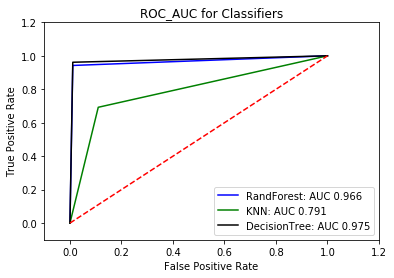

In [22]:
cmp = 0
colors = ['b', 'g', 'k']
models = {'RandForest': rfc, 'KNN': knn, 'DecisionTree': dtc}

for model_name, model in models.items() :
    predictions = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.3f'% (model_name,roc_auc))
    cmp += 1

plt.title('ROC_AUC for Classifiers')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

CONCLUSION

It is clear from these evaluation metrics that the <b> Decision Tree model outperforms the other models</b>. It attains over 95% in accuracy, specificity, sensitivity, and roc_auc score.

This is the model I am going to use as my best predictor, so let's explore what it tells us about the predictor variables...

<b> INTERPRETATION </b>

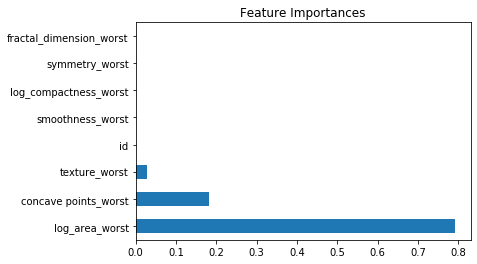

In [23]:
feat_importances = pd.Series(dtc.feature_importances_, index=X.columns)
feat_importances.nlargest(len(X.columns)).plot(kind='barh')

plt.title('Feature Importances')
plt.show()

It seems like the most influential variables measure :

<b> 1.) Size </b> ("area") 

<b> 2.) Shape </b> ("concave points", "texture") 

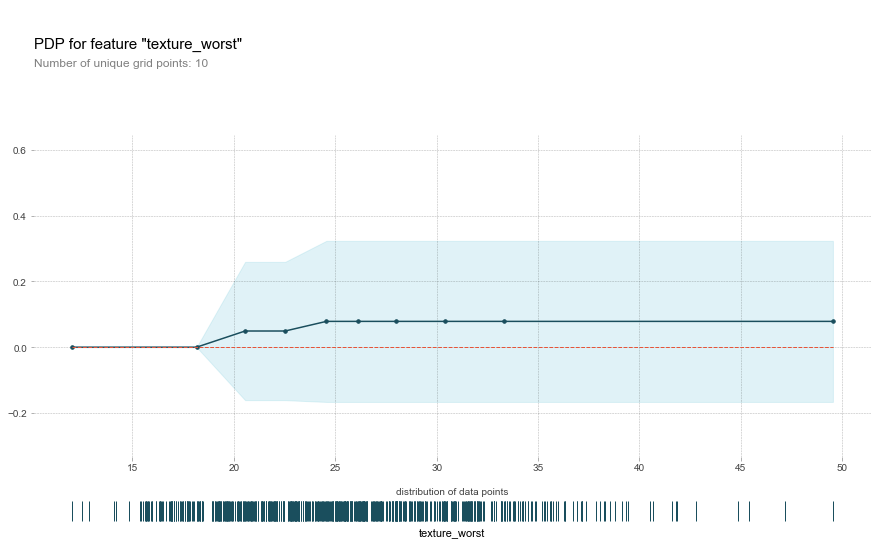

In [24]:
pdp_reviewcount = pdp_isolate(model=dtc,dataset=cancer_reduced,model_features=X.columns,feature='texture_worst')
fig, axes = pdp_plot(pdp_isolate_out=pdp_reviewcount,feature_name='texture_worst',plot_pts_dist=True)

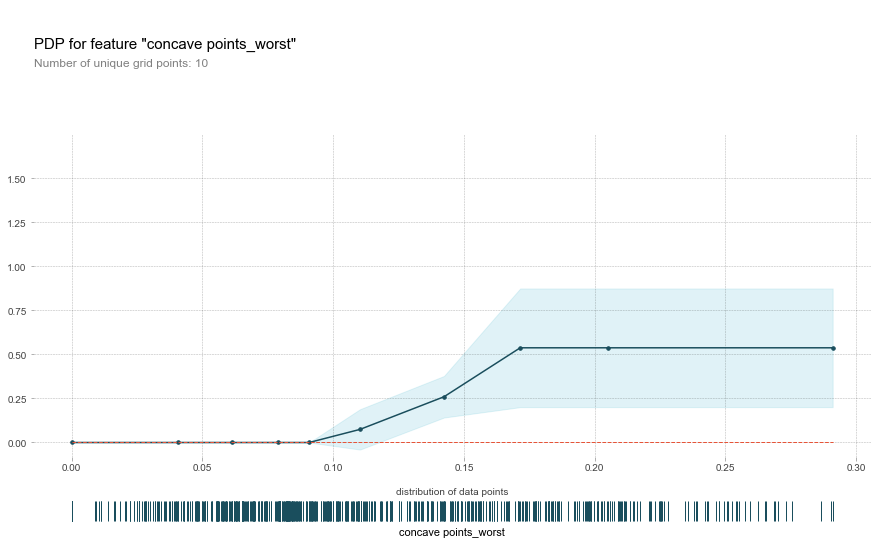

In [25]:
pdp_reviewcount = pdp_isolate(model=dtc,dataset=cancer_reduced,model_features=X.columns,feature='concave points_worst')
fig, axes = pdp_plot(pdp_isolate_out=pdp_reviewcount,feature_name='concave points_worst',plot_pts_dist=True)

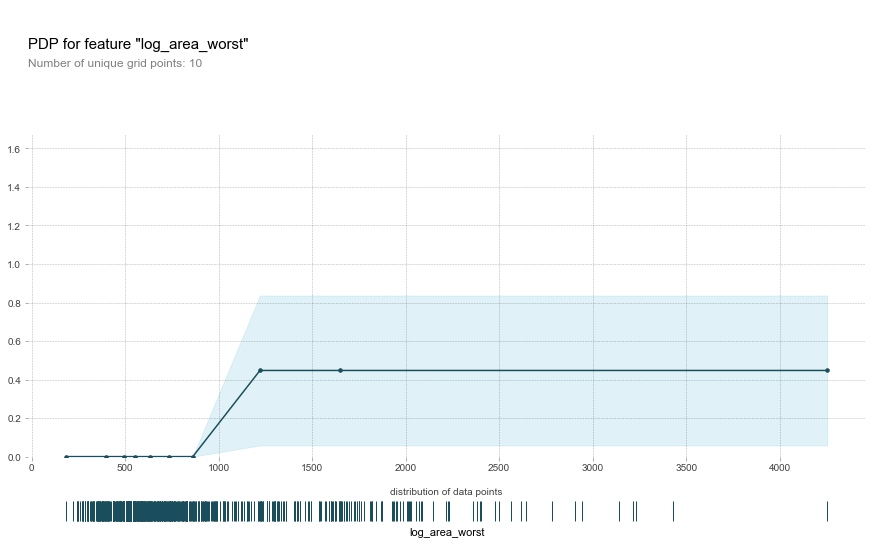

In [26]:
pdp_reviewcount = pdp_isolate(model=dtc,dataset=cancer_reduced,model_features=X.columns,feature='log_area_worst')
fig, axes = pdp_plot(pdp_isolate_out=pdp_reviewcount,feature_name='log_area_worst',plot_pts_dist=True)

In [27]:
X = cancer_reduced[['log_area_worst','concave points_worst','texture_worst']]
y = cancer_reduced['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=10)

In [28]:
dtc2 = DecisionTreeClassifier(max_depth = 3, random_state=10)
dtc.fit(X_train, y_train)
preds = dtc.predict(X_test)
accuracy = accuracy_score(y_test, preds)

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[90  1]
 [ 2 50]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        91
           1       0.98      0.96      0.97        52

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



<b> CONCLUSION </b>

Decision Tree Classifier results in over 96% accuracy, specificity, sensitivity, and ROC-AUC score using only 3 predictors.